<a href="https://colab.research.google.com/github/alessandrotofani/Tesi_magistrale/blob/master/6_Local_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
drive.mount('/content/drive')
from sklearn.model_selection import train_test_split

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys 
sys.path.append('/content/drive/MyDrive/Tesi_magistrale/Tesi_magistrale')
import mf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
!pip install --quiet fastai==2.2.5

# Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Tesi_magistrale/Dataset/IEEE/Output/data.csv')
data = mf.new_processing(data)

In [ ]:
def get_numerical_col(data, categorical_col):
  numerical_col = []
  for col in data.columns:
    if col not in categorical_col and col != 'isFraud':
      numerical_col.append(col)
  return numerical_col

cols = mf.get_col(data)
categorical_col = data.select_dtypes(include=['object']).columns.tolist()
numerical_col = get_numerical_col(data, categorical_col)

In [ ]:
from fastai.tabular.all import *
fasted = TabularPandas(data, procs=[Categorify],cat_names = categorical_col,cont_names = numerical_col,y_names='isFraud')

In [ ]:
X_train, y_train = fasted.xs, fasted.ys.values.ravel()

In [ ]:
categorical_col_toemb = []
one_hot_encode = []
for col in categorical_col:
  if X_train[col].max() > 7:
    categorical_col_toemb.append(col)
  else:
    one_hot_encode.append(col)

X_train = pd.get_dummies(X_train, columns=one_hot_encode)
cols = mf.get_col(X_train)
numerical_col = get_numerical_col(X_train, categorical_col_toemb)

In [ ]:
n_clients = 5
def mergeResult(X, y, col_name):
  y_res = y.reshape(np.shape(y)[0],1)
  data = np.concatenate((X,y_res), axis = 1)
  col_name.append('isFraud')
  dataset = pd.DataFrame(data=data, columns=col_name)
  col_name.remove('isFraud')
  return dataset

def splitData(data, n_clients):
  X = {}
  y = {}
  shuffled = data.sample(frac=1)
  result = np.array_split(shuffled, n_clients) 
  i = 0
  for dataset in result:
    y[i] = dataset['isFraud']
    X[i] = dataset.drop(columns=['isFraud'])
    i += 1
  return X, y

data = mergeResult(X_train, y_train, cols)
X, y = splitData(data, n_clients)

## Train validation test split

Splitto il dataset in train, validation e test set. 

In [ ]:
def overSampling(X, y, frac_over=0.1):
  from imblearn.over_sampling import SMOTE
  sm = SMOTE(sampling_strategy=frac_over, random_state=42)
  X_sm, y_sm = sm.fit_resample(X, y)  
  return X_sm, y_sm

In [ ]:
X_train = {}
y_train = {}
X_test = {}
X_val = {}
y_test = {}
y_val = {}
for i in range(n_clients):
  X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(X[i], y[i], test_size = 0.2)
  X_train[i], y_train[i] = overSampling(X_train[i], y_train[i])
  X_train[i], X_val[i], y_train[i], y_val[i] = train_test_split(X_train[i], y_train[i], test_size=0.25, random_state=42)

# Neural Network

Kaggle tutorial https://www.kaggle.com/colinmorris/embedding-layers

Implementation: https://www.kaggle.com/blaskowitz100/dnn-keras-and-categorical-feature-embedding

**************************************************************************************************************
Training model 0
Epoch 1/30
147/147 [==============================] - 9s 37ms/step - loss: 0.5189 - accuracy: 0.6887 - recall: 0.6920 - precision: 0.1857 - val_loss: 0.8106 - val_accuracy: 0.2085 - val_recall: 0.9869 - val_precision: 0.1021
Epoch 2/30
147/147 [==============================] - 4s 26ms/step - loss: 0.3998 - accuracy: 0.8048 - recall: 0.6922 - precision: 0.2643 - val_loss: 0.6528 - val_accuracy: 0.6051 - val_recall: 0.8874 - val_precision: 0.1737
Epoch 3/30
147/147 [==============================] - 4s 27ms/step - loss: 0.3872 - accuracy: 0.8140 - recall: 0.7156 - precision: 0.2908 - val_loss: 0.4535 - val_accuracy: 0.8333 - val_recall: 0.7249 - val_precision: 0.3180
Epoch 4/30
147/147 [==============================] - 4s 26ms/step - loss: 0.3716 - accuracy: 0.8229 - recall: 0.7292 - precision: 0.3062 - val_loss: 0.4280 - val_accuracy: 0.8270 - val_recall: 0.7

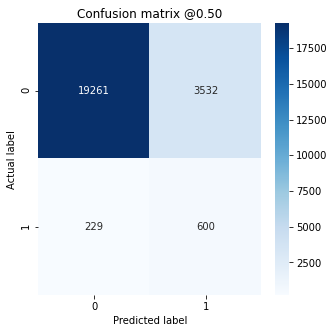

AUC:  0.856047586615936
Average precision:  0.36999527181081693
F1 score:  0.24188671638782502
Recall:  0.7237635705669482
Precision:  0.1452081316553727
**************************************************************************************************************
**************************************************************************************************************
Training model 1
Epoch 1/30
147/147 [==============================] - 8s 38ms/step - loss: 0.5581 - accuracy: 0.6700 - recall: 0.6564 - precision: 0.1695 - val_loss: 0.7400 - val_accuracy: 0.4359 - val_recall: 0.9285 - val_precision: 0.1316
Epoch 2/30
147/147 [==============================] - 4s 28ms/step - loss: 0.4339 - accuracy: 0.7881 - recall: 0.6686 - precision: 0.2519 - val_loss: 0.6211 - val_accuracy: 0.7257 - val_recall: 0.7545 - val_precision: 0.2142
Epoch 3/30
147/147 [==============================] - 4s 27ms/step - loss: 0.3962 - accuracy: 0.8128 - recall: 0.6962 - precision: 0.2810 - val_loss: 0.5417 

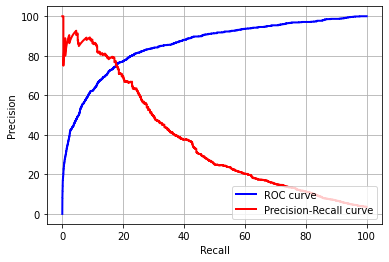

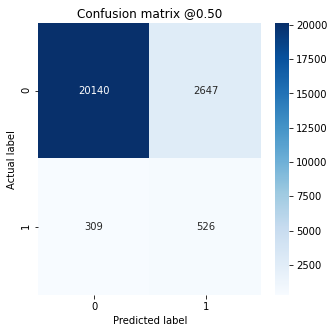

AUC:  0.8435870436684012
Average precision:  0.3420167062258391
F1 score:  0.2624750499001996
Recall:  0.629940119760479
Precision:  0.16577371572644184
**************************************************************************************************************
**************************************************************************************************************
Training model 2
Epoch 1/30
147/147 [==============================] - 8s 37ms/step - loss: 0.5411 - accuracy: 0.6803 - recall: 0.6689 - precision: 0.1781 - val_loss: 0.7875 - val_accuracy: 0.2811 - val_recall: 0.9766 - val_precision: 0.1098
Epoch 2/30
147/147 [==============================] - 4s 27ms/step - loss: 0.4222 - accuracy: 0.7938 - recall: 0.6819 - precision: 0.2609 - val_loss: 0.7087 - val_accuracy: 0.5594 - val_recall: 0.8991 - val_precision: 0.1587
Epoch 3/30
147/147 [==============================] - 4s 28ms/step - loss: 0.3910 - accuracy: 0.8147 - recall: 0.7104 - precision: 0.2916 - val_loss: 0.5518 -

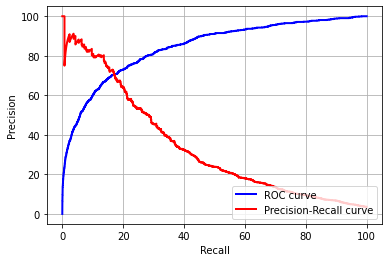

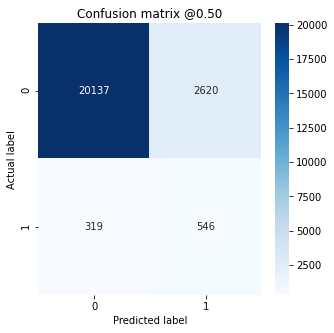

AUC:  0.8469121487360427
Average precision:  0.372456128399993
F1 score:  0.2709005209625403
Recall:  0.63121387283237
Precision:  0.1724573594440935
**************************************************************************************************************
**************************************************************************************************************
Training model 3
Epoch 1/30
147/147 [==============================] - 8s 36ms/step - loss: 0.5319 - accuracy: 0.6891 - recall: 0.6767 - precision: 0.1789 - val_loss: 0.9011 - val_accuracy: 0.1009 - val_recall: 0.9991 - val_precision: 0.0929
Epoch 2/30
147/147 [==============================] - 4s 28ms/step - loss: 0.4106 - accuracy: 0.7960 - recall: 0.7015 - precision: 0.2621 - val_loss: 0.7954 - val_accuracy: 0.4276 - val_recall: 0.9450 - val_precision: 0.1330
Epoch 3/30
147/147 [==============================] - 4s 27ms/step - loss: 0.3851 - accuracy: 0.8141 - recall: 0.7142 - precision: 0.2842 - val_loss: 0.7125 - va

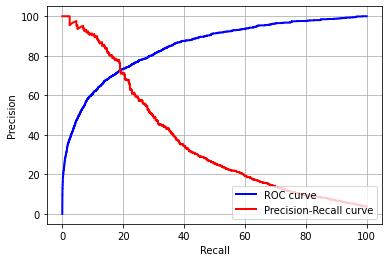

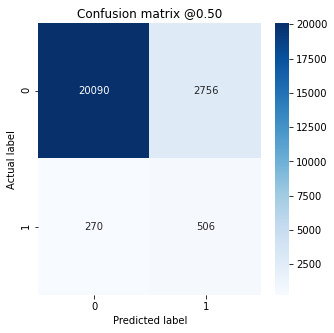

AUC:  0.8388883072766015
Average precision:  0.3289577844909145
F1 score:  0.2506191183754334
Recall:  0.6520618556701031
Precision:  0.15511955855303494
**************************************************************************************************************
**************************************************************************************************************
Training model 4
Epoch 1/30
148/148 [==============================] - 7s 36ms/step - loss: 0.5300 - accuracy: 0.6843 - recall: 0.6774 - precision: 0.1831 - val_loss: 0.7600 - val_accuracy: 0.3750 - val_recall: 0.9478 - val_precision: 0.1228
Epoch 2/30
148/148 [==============================] - 4s 27ms/step - loss: 0.4241 - accuracy: 0.7927 - recall: 0.6833 - precision: 0.2563 - val_loss: 0.6241 - val_accuracy: 0.6906 - val_recall: 0.8022 - val_precision: 0.2016
Epoch 3/30
148/148 [==============================] - 4s 28ms/step - loss: 0.3917 - accuracy: 0.8168 - recall: 0.7103 - precision: 0.2939 - val_loss: 0.5149 

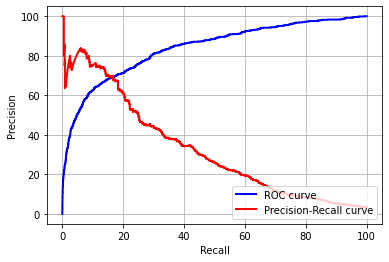

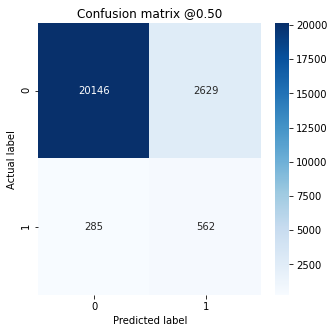

AUC:  0.8549791412060646
Average precision:  0.377250751708076
F1 score:  0.27835562159484895
Recall:  0.6635182998819362
Precision:  0.17612033845189595
**************************************************************************************************************


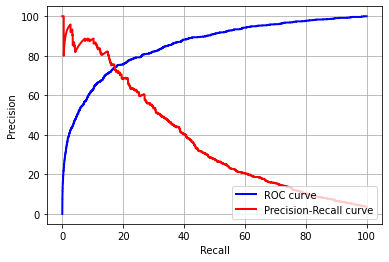

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.metrics import f1_score, recall_score, precision_score

for i in range(n_clients):
  keras.backend.clear_session()
  def get_keras_dataset(X, cols):
    df = pd.DataFrame(data=X, columns=cols)
    X = {str(col) : np.array(df[col]) for col in df.columns}
    return X

  categorical_input = []
  numerical_input = []
  embeddings = []
  embedding_layer_names = []
  for col in categorical_col_toemb:
  # for col in categorical_col:
      _input = layers.Input(shape=[1], name=col)
      _embed = layers.Embedding(fasted[col].max() + 1, 3, name=col+'_emb')(_input)
      categorical_input.append(_input)
      embeddings.append(_embed)
      embedding_layer_names.append(col+'_emb')
      
  # Simple inputs for the numeric features
  for col in numerical_col:
      numeric_input = layers.Input(shape=(1,), name=col)
      numerical_input.append(numeric_input)
      
  # Merge the numeric inputs
  merged_num_inputs = layers.concatenate(numerical_input)

  # Merge embedding and use a Droput to prevent overfittting
  merged_inputs = layers.concatenate(embeddings)
  spatial_dropout = layers.SpatialDropout1D(0.6)(merged_inputs) # 0.2
  flat_embed = layers.Flatten()(spatial_dropout)

  # Merge embedding and numeric features
  all_features = layers.concatenate([flat_embed, merged_num_inputs])

  # MLP for classification
  x = layers.Dense(360, activation=tf.keras.activations.gelu)(all_features) 
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.4)(x) #0.05 0.2

  # Final model
  output = layers.Dense(1, activation='sigmoid')(x)
  model = models.Model(inputs=categorical_input + numerical_input, outputs=output)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

  print('**************************************************************************************************************')
  print('Training model', i)
  history = model.fit(get_keras_dataset(X_train[i], cols), y_train[i], epochs=30, batch_size=512, validation_data=(get_keras_dataset(X_val[i], cols),y_val[i]),verbose=1,shuffle = True , class_weight = {0: 0.5, 1: 4})

  y_pred = model.predict(get_keras_dataset(X_test[i], cols))

  mf.plot_cm(y_test[i], y_pred, 'Blues')

  mf.plot_roc("ROC curve", y_test[i], y_pred,color='blue')
  
  mf.plot_ap('Precision-Recall curve', y_test[i], y_pred, color = 'red')

  y_predicted = []
  for prob in y_pred:
    if prob >= 0.5:
      y_predicted.append(1)
    else:
      y_predicted.append(0)

  print('F1 score: ',f1_score(y_test[i], y_predicted, average="binary"))
  print('Recall: ', recall_score(y_test[i], y_predicted, average='binary'))
  print('Precision: ', precision_score(y_test[i], y_predicted,  average='binary'))
  print('**************************************************************************************************************')
